# To complete:
* In order for the code to run on your environment, please make sure you read **INSTALL.md**
* Change the path variable to your project-path

In [1]:
!pip install -r requirements.txt;

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt;'
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
path = r'C:\Users\user\Desktop\NLP'

# Importing packages

In [3]:
import sys
import os

import pickle
import json

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot

import nltk
from nltk.stem.snowball import EnglishStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


# Basic functions we will use trough this project:
* **acc_loss** enables us to display the accuracy and the loss of the model through every epoch
* **stemmed_words** enables us to stem with english words

In [4]:
def acc_loss(nn_it):
    plt.style.use('ggplot')
    
    acc = nn_it.history['accuracy']
    val_acc = nn_it.history['val_accuracy']
    loss = nn_it.history['loss']
    val_loss = nn_it.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    
def stemmed_words(doc):
    return(stemmer.stem(w) for w in analyzer(doc))

# Pre-process
* The idea is to import the file and make sure the code can adapt if we had different filepath (i.e. differents files)
* We create a Train and Test datasets that we save in order not to run this code multiple times 

## Parameters:

In [5]:
test_size = 0.20

In [6]:
filepath_dict = {'mail': os.path.join(path, r'SMSSpamCollection.txt')}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names = ['label', 'sentence'], sep = '\t')
    df['source'] = source
    df_list.append(df)

# df = pd.concat(df.list) # If you have differents items in filepath_dict
df["label"] = df["label"].map( {"ham":0, "spam":1} ).astype(int)
print(df.iloc[0])

df_mail = df[df['source'] == 'mail']

sentences = df_mail['sentence'].values
y = df_mail['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=test_size, random_state=1337)

sentences_train.shape, sentences_test.shape

with open('pickle/xy.data', 'wb') as f:
    pickle.dump([sentences_train, sentences_test, y_train, y_test], f)

label                                                       0
sentence    Go until jurong point, crazy.. Available only ...
source                                                   mail
Name: 0, dtype: object


# Data Analysis

In [7]:
df.groupby('label').describe()

sentence                                                                 \
         count unique                                                top freq   
label                                                                           
0         4825   4516                             Sorry, I'll call later   30   
1          747    653  Please call our customer service representativ...    4   

      source                     
       count unique   top  freq  
label                            
0       4825      1  mail  4825  
1        747      1  mail   747

### Notes:
* Not all of the messages in our datasets are unique; for example the following message "Please call our customer service representativ..." appears 4 times. 
* This could potentially be a problem because it means that we might not have 747 distinct SPAM messages but far less...

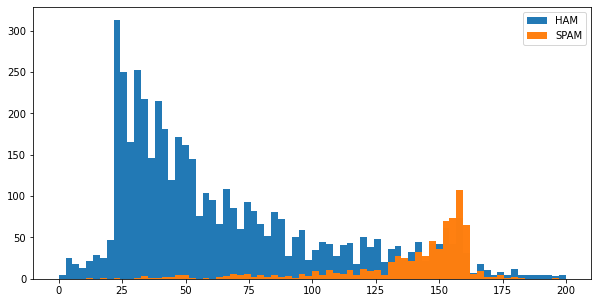

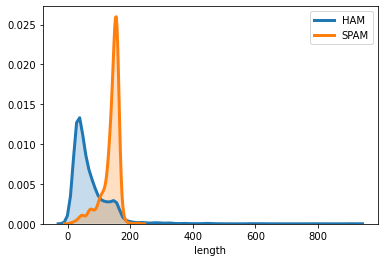

In [8]:
df_analysis = df
df_analysis['length'] = df_analysis['sentence'].apply(len)
df_analysis['nb_words'] = df_analysis['sentence'].str.split(" ").apply(len)
df_analysis_HAM = df_analysis.query("label == 0")
df_analysis_SPAM = df_analysis.query("label == 1")

bins = np.linspace(0, 200, 75)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplot(1, 1, 1)
pyplot.hist(df_analysis_HAM['length'], bins, alpha=0.99, label='HAM')
pyplot.hist(df_analysis_SPAM['length'], bins, alpha=0.99, label='SPAM')
pyplot.legend(loc='upper right')
pyplot.show()
plt.subplot(1, 1, 1)
sns.distplot(df_analysis_HAM['length'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "HAM")
sns.distplot(df_analysis_SPAM['length'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "SPAM")

fig.tight_layout()
plt.show()

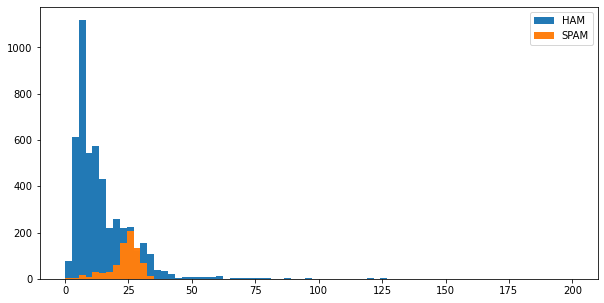

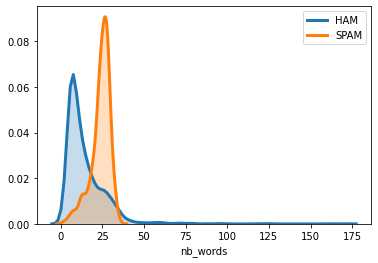

In [9]:
bins = np.linspace(0, 200, 75)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plt.subplot(1, 1, 1)
pyplot.hist(df_analysis_HAM['nb_words'], bins, alpha=0.99, label='HAM')
pyplot.hist(df_analysis_SPAM['nb_words'], bins, alpha=0.99, label='SPAM')
pyplot.legend(loc='upper right')
pyplot.show()

plt.subplot(1, 1, 1)
sns.distplot(df_analysis_HAM['nb_words'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "HAM")
sns.distplot(df_analysis_SPAM['nb_words'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "SPAM")
fig.tight_layout()
plt.show()

In [10]:
print("The number of median words for a HAM message is: {} whereas it is: {} for a SPAM message.".format(np.median(df_analysis_HAM["nb_words"]), np.median(df_analysis_SPAM["nb_words"]) ))
print("The number of median characters for a HAM message is: {} whereas it is: {} for a SPAM message.".format(np.median(df_analysis_HAM["length"]), np.median(df_analysis_SPAM["length"]) ))

The number of median words for a HAM message is: 11.0 whereas it is: 25.0 for a SPAM message.
The number of median characters for a HAM message is: 52.0 whereas it is: 149.0 for a SPAM message.


# Notes:
* Interesting fact: SPAM messages are usually longer (in terms of characters and number of words) than HAM messages.

### Simple Logistic Regression 
* The idea is to see how a common model would perform
* In order to compare to more complex models 

In [11]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer(stop_words = 'english').build_analyzer()

vectorizer = CountVectorizer(analyzer = stemmed_words)
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.979372197309417


In [12]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

vectorizer = CountVectorizer(analyzer = stemmed_words)
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.9802690582959641


### Notes
* Without removing stopwords we seems to get an higher accuracy 0.9802 > 0.9793

# Bag-Of-Words VS Word Embedding
* **Bag-of-words** and **Word Embedding** refer to different aspects of characterizing a body of text such as a document. They are described well in the textbook "Speech and Language Processing" by Jurafsky and Martin, 2009, in section 23.1 on information retrieval.
* We are going to first build a BoW (Bag-Of-Words) model as we have little data and then try to instantiate a Word Embedding Model


# Bag-Of-Words
* **Bag-of-words**: For a given document, you extract only the unigram words (aka terms) to create an unordered list of words. No POS tag, no syntax, no semantics, no position, no bigrams, no trigrams. Only the unigram words themselves, making for a bunch of words to represent the document. Thus: Bag-of-words.

In [13]:
with open('pickle/XY.data', 'rb') as f:
    sentences_train, sentences_test, y_train, y_test = pickle.load(f)
    
sentences_train.shape, sentences_test.shape, y_train.shape, y_test.shape

if len(sentences_train) == len(y_train) and len(sentences_test) == len(y_test):
    print("We're good to go !")
else:
    print("There might be a problem with our Train and Test datasets's shape")

We're good to go !


### Parameters of CountVectorizer
* **stop_words['english','french',...] :** enables us to delete stopwords in english (i.e. be, until, and and so on...)
* **lowercase[True/False] :**  speaks for itself
* **ngram_range[(1,n)] :** which sets the number of consecutive words to put on the vocabulary dictionnary. This is an important parameters that needs to be set carefully. Indeed, as *n* increases, the vocabulary size increases exponentially! Let me illustrate with a simple example. "very shiny" is a 2-gram that is considered as an extra feature separatly from "very" and "shiny" when you have a n-gram range of (1,2). In our case, we have a vocabulary size of 31416 with a n-gram range of (1,2) whereas a vocabulary size of 7442 with a n-gram range of (1,1). As our dataset is really small we decided to take a n-gram of (1,2).

In [14]:
vectorizer = CountVectorizer(stop_words = 'english',
                             lowercase = True,
                             ngram_range = (1,2))
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

### **The vocabulary**

In [15]:
print("Vocabulary size: {}".format(len(vectorizer.fit(sentences_train).vocabulary_)))
print("Vocabulary content:\n {}".format(vectorizer.fit(sentences_train).vocabulary_))

Vocabulary size: 31416
Vocabulary content:
 {'busy': 4579, 'come': 5913, 'point': 21065, 'figure': 9813, 'doing': 8157, 'tomorrow': 27681, 'busy come': 4581, 'come point': 5986, 'point figure': 21067, 'figure doing': 9814, 'doing tomorrow': 8199, 'willing': 30252, 'apps': 2700, 'class': 5624, 'willing apps': 30254, 'apps class': 2701, 'charges': 5247, 'transfer': 27946, 'withdraw': 30395, 'like': 15751, 'charges transfer': 5250, 'transfer charges': 27949, 'charges withdraw': 5251, 'withdraw like': 30396, 'just': 14470, 'sent': 23814, 'email': 8937, 'address': 2034, 'incomm': 13838, 'right': 22768, 'just sent': 14608, 'sent email': 23826, 'email address': 8940, 'address incomm': 2040, 'incomm right': 13839, 'pick': 20619, 'bout': 4162, '30ish': 1060, 'time': 27305, 'going': 11171, 'pick bout': 20625, 'bout 30ish': 4164, '30ish time': 1062, 'time going': 27339, 'wat': 29683, 'dear': 7321, 'sleeping': 24565, 'ah': 2202, 'wat dear': 29693, 'dear doing': 7333, 'doing sleeping': 8192, 'sleep

In [16]:
input_dim = X_train.shape[1]  # Number of features

def BagOfWords_NN():
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Dense(256, input_dim = input_dim)(inputs)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

model = BagOfWords_NN()
model.compile(loss='binary_crossentropy', # Binary Classification SPAM/HAM
              optimizer='adam',           # Adam optimization algorithm is an extension to stochastic gradient
              metrics=['accuracy'])       # Metrics we want to maximize
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 31416)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8042752   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 8,043,009
Trainable params: 8,043,009
Non-trainable params: 0
_________________________________________________________________


In [17]:
nn_it = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_split = 0.2,
                    batch_size=128,
                    callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.001)])                 
model.save('h5df/model.BOW')

Train on 3565 samples, validate on 892 samples
Epoch 1/50
3565/3565 [==============================] - 4s 1ms/step - loss: 0.3606 - accuracy: 0.9532 - val_loss: 0.1600 - val_accuracy: 0.9787
Epoch 2/50
3565/3565 [==============================] - 3s 950us/step - loss: 0.0579 - accuracy: 0.9969 - val_loss: 0.0957 - val_accuracy: 0.9787
Epoch 3/50
3565/3565 [==============================] - 3s 946us/step - loss: 0.0225 - accuracy: 0.9992 - val_loss: 0.0845 - val_accuracy: 0.9776
Epoch 4/50
3565/3565 [==============================] - 3s 956us/step - loss: 0.0126 - accuracy: 0.9994 - val_loss: 0.0820 - val_accuracy: 0.9776
Epoch 5/50
3565/3565 [==============================] - 3s 932us/step - loss: 0.0083 - accuracy: 0.9994 - val_loss: 0.0823 - val_accuracy: 0.9776


In [18]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9953
Testing Accuracy:  0.9713


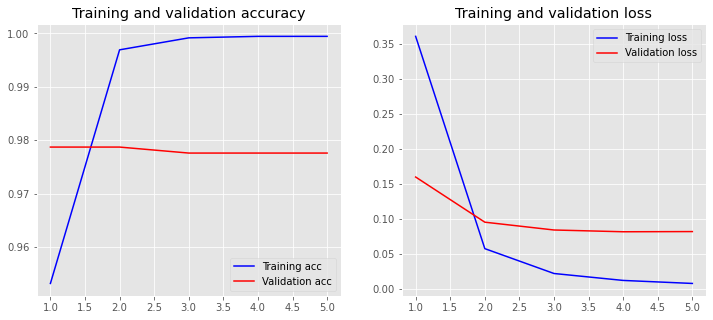

In [19]:
acc_loss(nn_it)

# Notes:
* Even though we set 50 epochs, early stopping stopped at 15 epochs. 
* Overfitting happens when the validation loss curve (red on the right) starts rising. Hence we are not overfitting.
* This was one of the simplest NN possible which explains why there is such a huge difference between training and validations accuracy/loss.

# Word Embedding
* Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. Word embeddings are distributed representations of text in an n-dimensional space. These are essential for solving most NLP problems.
* Word2Vec one of the most used forms of word embedding is described by Wikipedia as: “Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.”
* In our case, we will not use pre-trained model like Word2vec or Glove because these are huge files (~ 1GB for Glove).
* Instead, we will make OUR dictionnary

## Parameters to set:

In [20]:
num_words = 1000
maxlen = 150
embedding_dim = 50

In [21]:
tokenizer = Tokenizer(num_words=num_words,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # Removing special characters as well as punctuation
                      lower=True,                                     # Keep the distinct. bc it is important in Spam detection
                      split=' ',                                      # "Words are set of char splitted by a space"
                      char_level=False)                               # If True, every character will be treated as a token
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print("Original sentence: {} ".format(sentences_train[1]) )
print("Tokenized sentence: {} ".format(X_train[1]))

Original sentence: Are you willing to go for apps class. 
Tokenized sentence: [22, 3, 2, 45, 12, 296] 


### Process the data
* **Note**: Pay close attention to the difference between this technique and the X_train that was produced by scikit-learn’s CountVectorizer.
* With CountVectorizer, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary tokenizer.word_index.

In [22]:
for word in ['hi', 'hi', 'hello', 'there']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

hi: 100
hi: 100
hello: 250
there: 70


### Padding
* One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros.

In [23]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

count = 0
for i in X_train:
    if len(X_train[i]) == maxlen:
        count = count + 1 
    else:
        count = count
if count == len(X_train):
    print("Padding worked fine")
else: print("Problem with padding")

Padding worked fine


In [24]:
def def_flat_NN():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(input_dim = vocab_size, 
                      output_dim = embedding_dim, 
                      input_length = maxlen)(inputs)
    layer = Flatten()(layer)
    layer = Dense(10, activation = 'relu')(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

model = def_flat_NN()
model.compile(optimizer='adam',            # Adam optimization algorithm is an extension to stochastic gradient
              loss='binary_crossentropy',  # Binary Classification SPAM/HAM
              metrics=['accuracy'])        # Metrics we want to maximize
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           397950    
_________________________________________________________________
flatten_1 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                75010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 472,971
Trainable params: 472,971
Non-trainable params: 0
_________________________________________________________________


In [25]:
nn_it = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_split = 0.2,
                    batch_size=128,
                    callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.000001)])

model.save('h5df/model.WE')

Train on 3565 samples, validate on 892 samples
Epoch 1/50
3565/3565 [==============================] - 0s 130us/step - loss: 0.4194 - accuracy: 0.8516 - val_loss: 0.3676 - val_accuracy: 0.8576
Epoch 2/50
3565/3565 [==============================] - 0s 74us/step - loss: 0.2912 - accuracy: 0.8668 - val_loss: 0.2367 - val_accuracy: 0.8576
Epoch 3/50
3565/3565 [==============================] - 0s 73us/step - loss: 0.1767 - accuracy: 0.8668 - val_loss: 0.1724 - val_accuracy: 0.8576
Epoch 4/50
3565/3565 [==============================] - 0s 71us/step - loss: 0.1418 - accuracy: 0.9576 - val_loss: 0.1472 - val_accuracy: 0.9720
Epoch 5/50
3565/3565 [==============================] - 0s 72us/step - loss: 0.1229 - accuracy: 0.9801 - val_loss: 0.1362 - val_accuracy: 0.9776
Epoch 6/50
3565/3565 [==============================] - 0s 77us/step - loss: 0.1122 - accuracy: 0.9849 - val_loss: 0.1337 - val_accuracy: 0.9776
Epoch 7/50
3565/3565 [==============================] - 0s 73us/step - loss: 0.104

In [26]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9888
Testing Accuracy:  0.9740


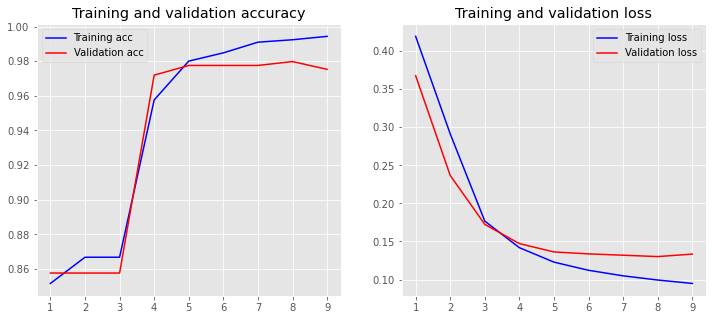

In [27]:
acc_loss(nn_it)

# Notes:
* We can clearly see that our validation accuracy follows perfectly the training accuracy until 0.96%.
* Loss plot shows that we are not overfitting.

# Let's instantiate a LSTM - Long-Short-Term-Memory Model
* LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.
* A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

## Parameters to set:

In [28]:
num_words = 1000
maxlen = 150
embedding_dim = 50

In [29]:
def def_LSTM():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(input_dim = num_words, output_dim = embedding_dim, input_length = maxlen)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

model = def_LSTM()
model.compile(optimizer='adam',            # Adam optimization algorithm is an extension to stochastic gradient
              loss='binary_crossentropy',  # Binary Classification SPAM/HAM
              metrics=['accuracy'])        # Metrics we want to maximize
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257 

In [30]:
nn_it = model.fit(X_train, y_train,
          epochs=10,
          verbose=True,
          validation_split = 0.2,
          batch_size=128,
          callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001)])

model.save('h5df/model.WE_LSTM')

Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 5s 1ms/step - loss: 0.4731 - accuracy: 0.8569 - val_loss: 0.3391 - val_accuracy: 0.8576
Epoch 2/10
3565/3565 [==============================] - 4s 1ms/step - loss: 0.2063 - accuracy: 0.9100 - val_loss: 0.1078 - val_accuracy: 0.9742
Epoch 3/10
3565/3565 [==============================] - 4s 1ms/step - loss: 0.0590 - accuracy: 0.9820 - val_loss: 0.0519 - val_accuracy: 0.9832
Epoch 4/10
3565/3565 [==============================] - 4s 1ms/step - loss: 0.0311 - accuracy: 0.9899 - val_loss: 0.0451 - val_accuracy: 0.9843
Epoch 5/10
3565/3565 [==============================] - 4s 1ms/step - loss: 0.0208 - accuracy: 0.9952 - val_loss: 0.0482 - val_accuracy: 0.9821


In [31]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9939
Testing Accuracy:  0.9830


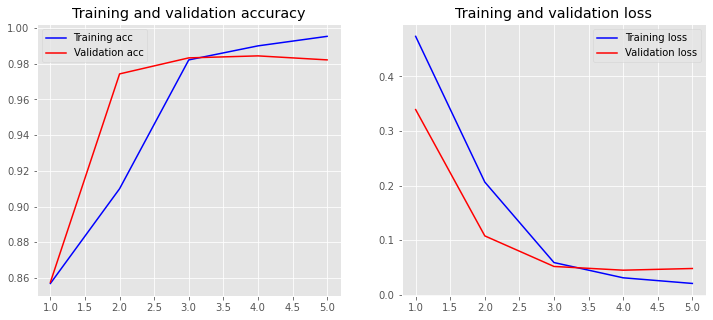

In [32]:
acc_loss(nn_it)

# Notes:
* Surprised that our validation accuracy is better than our training accuracy until the third epoch.
* Loss plot shows that we are not overfitting until the third epoch. Indeed, from the third epoch validation loss starts to rise.